# Packages

In [ ]:
import numpy as np

# TMSD and EB

In [ ]:
def TMSD(traj, t_lags):
    '''Calculate the time average mean squared displacement of a set of trajectories'''
    ttt = np.zeros_like(t_lags, dtype= float)
    for idx, t in enumerate(t_lags):        
        for p in range(len(traj)-t):
            ttt[idx] += (traj[p]-traj[p+t])**2            
        ttt[idx] /= len(traj)-t    
    return ttt

# This one is more efficient (?)
def TMSD_array(trajs, t_lags):
    ttt = np.zeros((trajs.shape[0], len(t_lags)))
    for idx, t in enumerate(t_lags):        
        for p in range(trajs.shape[1]-t):
            ttt[:, idx] += (trajs[:, p]-trajs[:, p+t])**2            
        ttt[:, idx] /= len(trajs)-t 
    return ttt

def EB(trajs, t_lag):
    eb = []
    for T in range(t_lag+1, trajs.shape[1]):
        tmsd = TMSD_array(trajs[:,:T], [t_lag])
        bef = np.mean(np.array(tmsd)**2)
        aft = np.mean(tmsd)**2

        eb.append(bef/aft-1)
    return eb

## Fitting tmsd

In [ ]:
for traj in X1[0]:
    t_lags = np.arange(1, max(10, int(0.1*len(traj))))

    tmsd = TMSD(traj, t_lags)
    P.append(np.polyfit(np.log(t_lags), np.log(tmsd),1)[0])



## Effect of noise in TMSD

In [50]:
trajs = andi.andi_datasets().create_dataset(T=1000, N = 1000, exponents = [0.7], models = [2])

In [39]:
msd = np.mean(trajs[:,2:]**2, axis = 0)
msd_n = np.mean((trajs[:,2:]+0.1*np.random.randn(1000,100))**2, axis = 0)

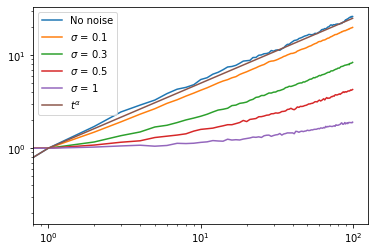

In [49]:
plt.loglog(msd/msd[1], label = 'No noise')
for noise in [0.1, 0.3, 0.5,1]:
    msd_n = np.mean((trajs[:,2:]+noise*np.random.randn(1000,1000))**2, axis = 0)
    plt.loglog(msd_n/msd_n[1], label = f'$\sigma$ = {noise}')

plt.loglog(np.arange(100)**(0.7), label = r'$t^\alpha$')
plt.legend()

# Create a dataset from ANDI and use it in a CNN

In [74]:
ad = andi.andi_datasets()
N = 1000
T = 20
processes = [0,2]
exponents = np.arange(0.1,1,0.05)

dataset = ad.create_dataset(T =T, N = N, exponents = exponents, models = processes, 
                              load_trajectories = True, path = '/home/gmunoz/andi_data/datasets/', t_save=30)
np.random.shuffle(dataset)

Then, we separate the datasets in a training/test set dataset with ratio 80-20

**Adapt the labels to normal/sub/super**

In [75]:
# separating dataset
ratio = int(0.8*dataset.shape[0])
X_a = normalize(dataset[:ratio, 2:]).reshape(ratio, T, 1)
X_e = normalize(dataset[ratio:, 2:]).reshape(N-ratio, T, 1)

dataset[dataset[:,0] == 2, 0] = 1
#dataset[dataset[:,0] == 4, 0] = 3
Y_a = to_categorical(dataset[:ratio, 0])
Y_e = to_categorical(dataset[ratio:, 0])

expo_e = dataset[ratio:,1]

X_e.shape

(7200, 20, 1)

# Define a NN

In [ ]:
model = Sequential()


model.add(Conv1D(filters=3, kernel_size=3 ,strides=1,   
                 input_shape=(T, 1),
                 kernel_initializer= 'uniform',      
                 activation= 'relu', kernel_regularizer = regularizer_l2(l = 0.001)))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))

model.add(Conv1D(filters=8, kernel_size=5 ,strides=1,  
                 kernel_initializer= 'uniform',      
                 activation= 'relu', kernel_regularizer = regularizer_l2(l = 0.001)))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))   

model.add(Conv1D(filters=3, kernel_size=2 ,strides=1,  
                 kernel_initializer= 'uniform',      
                 activation= 'relu', kernel_regularizer = regularizer_l2(l = 0.001)))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64*2, activation='sigmoid', kernel_regularizer = regularizer_l2(l = 0.001)))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))

model.add(Dropout(0.5))
model.add(Dense(64, activation='sigmoid'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))

####### CHANGE THIS ##########
model.add(Dense(len(processes), activation='softmax'))

model.compile(loss='kullback_leibler_divergence',
              optimizer=Adam(),
              metrics=['accuracy'])
